## Fake User Detection

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [153]:
df_raw = pd.read_csv('../data/fake_users.csv')
df_raw.head()

,Unnamed: 0,UserId,Event,Category,Fake
0,0,F7A7BF3761,click_carrousel,Phone,0
1,1,BA8F7A71E6,send_sms,Motor,0
2,2,21C64F22FC,send_email,Jobs,0
3,3,F9E0306603,send_sms,Jobs,0
4,4,1B2143BACC,click_ad,Phone,0


In [154]:
data = df_raw.copy()
data = data.drop(['Unnamed: 0'], axis=1)

### EDA

Let's do some preliminary EDA to confirm the research conducted by the internal team with respect to behaviour of these bots 

array([[<AxesSubplot:title={'center':'Fake'}>]], dtype=object)

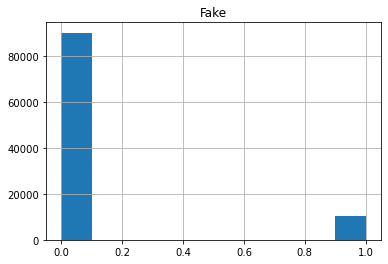

In [155]:
# We observe that our dataset in quite unbalanced
data.hist(column = 'Fake')

In [156]:
data[data['Fake'] == 1]['Event'].value_counts()

send_email         4600
click_ad           4213
click_carrousel     540
send_sms            515
phone_call          491
Name: Event, dtype: int64

In [157]:
data[data['Fake'] == 0]['Event'].value_counts()

send_email         18222
click_carrousel    18128
click_ad           17988
phone_call         17939
send_sms           17837
Name: Event, dtype: int64

Clearly the distribution of clicks for bots tends to be skewed towards clicks like click_ad and send_email

### Feature Engineering

For our features we will calculate them on a per user basis. 
*Number of categories, Count for each category, Number of events, Count of each event type*

In [158]:
new_df_list = []
users = list(data['UserId'].unique())

In [159]:
for user_id in users:
    user = data[data['UserId'] == user_id]
    fake = user.Fake.to_list()[0]
    user_number_of_categories = user['Category'].nunique()
    user_category_counts = user['Category'].value_counts()
    user_number_of_events = user['Event'].nunique()
    user_event_counts = user['Event'].value_counts()
    user_event_counts_df = pd.DataFrame(user_event_counts).transpose().reset_index(drop=True)
    user_category_counts_df = pd.DataFrame(user_category_counts).transpose().reset_index(drop=True)
    df = pd.concat([user_event_counts_df, user_category_counts_df], axis=1)
    df['user_number_of_categories'] = user_number_of_categories
    df['user_number_of_events'] = user_number_of_events
    df['fake'] = fake
    df['user'] = user_id
    new_df_list.append(df.iloc[0].to_dict())



In [160]:
new_df = pd.DataFrame(new_df_list)
new_df.fillna(0, inplace=True)
new_df.head()

,click_ad,click_carrousel,send_email,phone_call,send_sms,Phone,Leisure,Motor,Holidays,user_number_of_categories,user_number_of_events,fake,user,Jobs,Real_State
0,6.0,4.0,3.0,2.0,1.0,12.0,2.0,1.0,1.0,4,5,0,F7A7BF3761,0.0,0.0
1,3.0,2.0,3.0,2.0,5.0,0.0,0.0,14.0,0.0,2,5,0,BA8F7A71E6,1.0,0.0
2,5.0,3.0,6.0,3.0,3.0,0.0,1.0,1.0,0.0,4,5,0,21C64F22FC,16.0,2.0
3,2.0,4.0,4.0,5.0,1.0,0.0,1.0,1.0,0.0,4,5,0,F9E0306603,13.0,1.0
4,2.0,3.0,3.0,4.0,3.0,11.0,0.0,0.0,0.0,2,5,0,1B2143BACC,0.0,4.0


### Model Training

For training we use Pycaret (wrapper around scikit-learn) to speed up and streamline the model training process

In [161]:
dataset = new_df
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (5035, 15)
Unseen Data For Predictions: (265, 15)


In [162]:
list(new_df.columns).remove('fake')

In [163]:
from pycaret.classification import *
exp_clf101 = setup(data = data, 
                    target = 'fake', session_id=1, 
                    numeric_features = ['click_ad', 'click_carrousel', 'send_email', 'phone_call', 'send_sms',
                    'Phone', 'Leisure', 'Motor', 'Holidays', 'user_number_of_categories',
                    'user_number_of_events', 'user', 'Jobs', 'Real_State'],
                    ignore_features = ['user']
     ) 

,Description,Value
0,session_id,1
1,Target,fake
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(5035, 15)"
5,Missing Values,False
6,Numeric Features,13
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [164]:
best_model = compare_models(fold = 5, include=['knn', 'rf', 'nb'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,20.6700
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.3840
nb,Naive Bayes,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0480


We can see our models are pretty much getting the classification 100% accurately. To make sure we are not overfitting we must use our test data

In [165]:
knn = create_model('knn', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Mean,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
SD,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [166]:
df_raw_test = pd.read_csv('../data/fake_users_test.csv')
data = df_raw_test

new_df_list = []
users = list(data['UserId'].unique())

for user_id in users:
    user = data[data['UserId'] == user_id]
    fake = user.Fake.to_list()[0]
    user_number_of_categories = user['Category'].nunique()
    user_category_counts = user['Category'].value_counts()
    user_number_of_events = user['Event'].nunique()
    user_event_counts = user['Event'].value_counts()
    user_event_counts_df = pd.DataFrame(user_event_counts).transpose().reset_index(drop=True)
    user_category_counts_df = pd.DataFrame(user_category_counts).transpose().reset_index(drop=True)
    df = pd.concat([user_event_counts_df, user_category_counts_df], axis=1)
    df['user_number_of_categories'] = user_number_of_categories
    df['user_number_of_events'] = user_number_of_events
    df['fake'] = fake
    df['user'] = user_id
    new_df_list.append(df.iloc[0].to_dict())
    # print(user_id)

new_df = pd.DataFrame(new_df_list)
new_df = new_df.fillna(0)

In [167]:
unseen_predictions = predict_model(knn, data=new_df)
unseen_predictions.head()

,phone_call,click_ad,send_email,send_sms,click_carrousel,Phone,Jobs,Motor,Holidays,Real_State,user_number_of_categories,user_number_of_events,fake,user,Leisure,Label,Score
0,6.0,4.0,2.0,2.0,1.0,11.0,1.0,1.0,1.0,1.0,5,5,0,03E7EE785DT,0.0,0,1.0
1,2.0,7.0,4.0,1.0,4.0,0.0,2.0,0.0,1.0,14.0,4,5,0,F0F3098683T,1.0,0,1.0
2,6.0,2.0,3.0,5.0,3.0,16.0,1.0,0.0,1.0,1.0,4,5,0,5064A38F0DT,0.0,0,1.0
3,4.0,2.0,5.0,5.0,4.0,0.0,0.0,18.0,1.0,0.0,3,5,0,5C8E90A354T,1.0,0,1.0
4,2.0,2.0,2.0,1.0,9.0,1.0,0.0,14.0,0.0,0.0,3,5,0,DC1F29D286T,1.0,0,1.0


In [168]:
from pycaret.utils import check_metric
score = check_metric(unseen_predictions['fake'], unseen_predictions['Label'], metric = 'Accuracy')
print("Accuracy score: {}".format(score))

Accuracy score: 1.0


In [169]:
_ = save_model(knn,'../models/model')

Transformation Pipeline and Model Successfully Saved


We still get a perfect score on the test dataset

- we didn't even have to balance our dataset for this. In other cases, that could be a good avenue to explore
- our model looks perfect for the data collected for this window. However, more data over larger windows or even periods will be good to properly calibrate such a model